# Vivino Wine Analysis

## 1) Project details

### Dataset generation and construction

Our initial approach was to search for existing wine datasets suitable for analyzing wine quality and characteristics. However, after reviewing available public datasets—such as the [UCI Wine Quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality), we found they were not aligned with our analytical goals. These datasets typically focus on physicochemical properties (fixed acidity, volatile acidity, pH, sulphates, etc.) from a scientific perspective, but lack critical market-driven and consumer-oriented information such as price, country of origin, grape varieties, and aromatic profiles.

Since Vivino is the leading reference platform for wine ratings and encompasses a comprehensive range of consumer preferences and wine characteristics, we decided to generate our own dataset by scraping data through the Vivino API. This approach allowed us to selectively extract the specific variables most relevant to our analysis: sensory characteristics, user ratings, grape varieties, country of origin, price ranges, and aromatic profiles.

### Scrapping
TODO -> explain what and how we scape

In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

In [25]:
# Load Data
try:
    df = pd.read_csv('data/25-11-2025.csv')
    print("Data loaded successfully!")
    display(df.head())
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please check the path 'data/25-11-2025.csv'")

Data loaded successfully!


,id,name,vintage,country,winery,grapes,rating,price,acidity,intensity,sweetness,tannin,flavor_rank1,flavor_rank2,flavor_rank3
0,2446729,Masseto Toscana 2005,2005,Italie,Masseto,Cabernet Sauvignon;Merlot;Sangiovese;Canaiolo ...,4.8,2138.75,3.098834,3.625233,1.987469,3.142972,oak,black_fruit,earth
1,1286354,Domaine de La Romanée-Conti Grands-Échezeaux G...,2015,France,Domaine de La Romanée-Conti,Pinot Noir,4.8,9330.55,4.039444,2.989543,2.013161,2.566732,red_fruit,earth,oak
2,83911,Domaine de La Romanée-Conti La Tâche Grand Cru...,2008,France,Domaine de La Romanée-Conti,Pinot Noir,4.8,11391.60,4.054916,3.045306,1.942342,2.616129,earth,red_fruit,black_fruit
3,83920,Domaine de La Romanée-Conti Romanée-Saint-Viva...,2015,France,Domaine de La Romanée-Conti,Pinot Noir,4.8,4949.00,4.098835,3.028463,1.913652,2.593252,red_fruit,earth,oak
4,83917,Domaine de La Romanée-Conti Échezeaux Grand Cr...,2015,France,Domaine de La Romanée-Conti,Pinot Noir,4.8,8812.19,4.100403,3.041206,1.991335,2.603384,red_fruit,earth,oak


Dataset shape: (2065, 15)


## 1. Data Exploratory Analysis & Unsupervised Exploration
In this section, we will explore the dataset to understand the distribution of variables, correlations, and potential outliers. We will also perform unsupervised exploration if applicable (e.g., clustering).

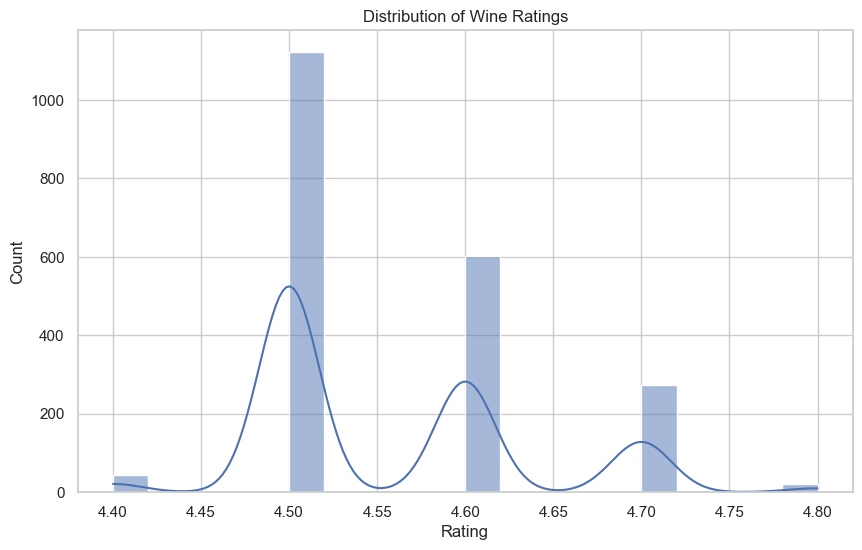

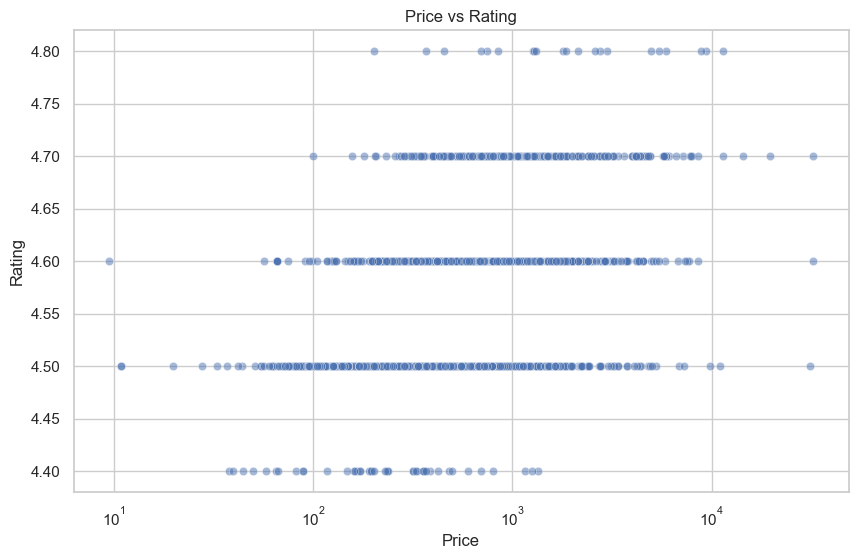

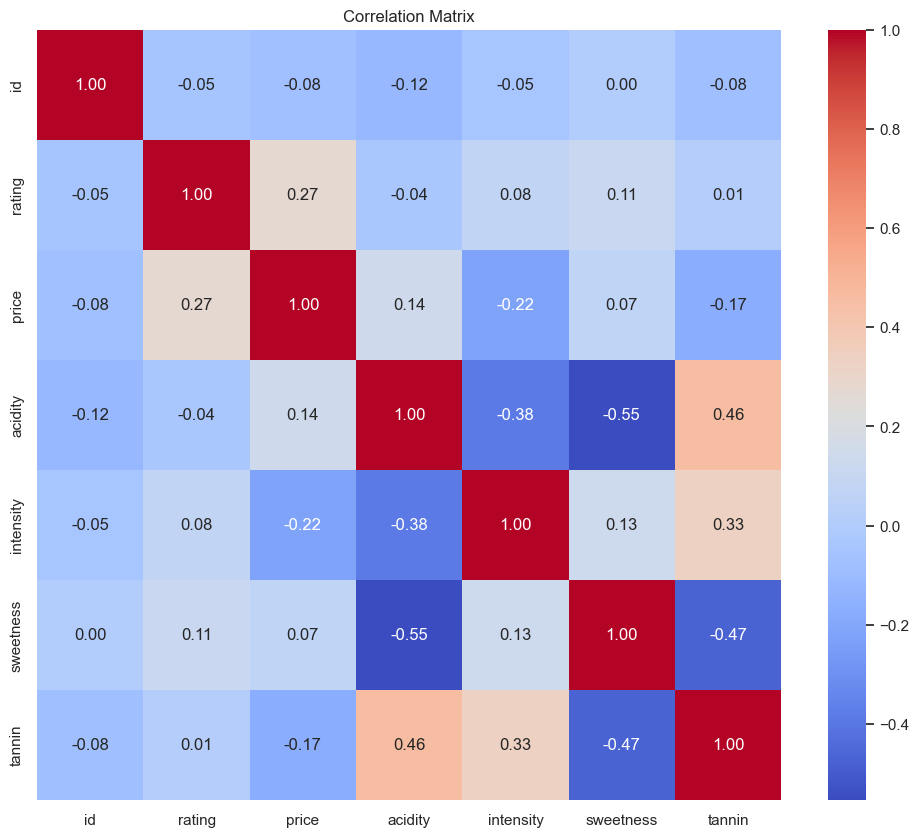

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2065 entries, 0 to 2064
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2065 non-null   int64  
 1   name          2065 non-null   object 
 2   vintage       2063 non-null   object 
 3   country       2065 non-null   object 
 4   winery        2065 non-null   object 
 5   grapes        2060 non-null   object 
 6   rating        2065 non-null   float64
 7   price         2065 non-null   float64
 8   acidity       2064 non-null   float64
 9   intensity     2064 non-null   float64
 10  sweetness     2064 non-null   float64
 11  tannin        2064 non-null   float64
 12  flavor_rank1  2030 non-null   object 
 13  flavor_rank2  2023 non-null   object 
 14  flavor_rank3  2023 non-null   object 
dtypes: float64(6), int64(1), object(8)
memory usage: 242.1+ KB


,id,rating,price,acidity,intensity,sweetness,tannin
count,2.065000e+03,2065.00000,2065.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,1.578016e+06,4.55661,885.118295,3.675197,3.878056,1.827872,3.434563
std,2.259112e+06,0.07848,1735.449417,0.539142,0.516744,0.318466,0.554874
min,1.264000e+03,4.40000,9.450000,1.813413,2.455588,1.000000,1.625294
25%,7.744900e+04,4.50000,260.000000,3.371021,3.517255,1.672948,3.019276
50%,1.145116e+06,4.50000,465.000000,3.725878,3.942359,1.768720,3.481038
75%,1.655970e+06,4.60000,895.000000,4.097786,4.183863,1.904835,3.867878
max,1.343534e+07,4.80000,32460.000000,4.782415,5.000000,3.569340,4.755028


In [26]:
# EDA: Visualizations

# Price vs Rating scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='price', y='rating', alpha=0.6, s=50)
plt.title('Wine Price vs Rating', fontsize=16)
plt.xlabel('Price (€)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

df.info()
df.describe()


## 2. Data preprocessing, preparation & train-val-test splits
Here we will prepare the data for modeling. This includes handling missing values, encoding categorical variables, scaling features, and splitting the data into training, validation, and test sets.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

# --- 1. Définition des fonctions utilitaires ---
def split_semicolon(text):
    """Fonction de tokenization pour CountVectorizer"""
    # Séparer par point-virgule et nettoyer les espaces
    return [x.strip() for x in text.split(';')]

# --- 2. Préparation des données (Target vs Features) ---
# On retire la target ('rating') et les identifiants inutiles
X = df.drop(['rating', 'id', 'name'], axis=1)
y = df['rating']

# Conversion de la colonne vintage en numérique (gestion des 'N.V.')
X['vintage'] = pd.to_numeric(X['vintage'], errors='coerce')

# --- 3. Définition des groupes de features ---
numeric_features = ['vintage', 'price', 'acidity', 'intensity', 'sweetness', 'tannin']
# Note : 'grapes' est retiré des categorical car il a son propre traitement
categorical_features = ['country', 'winery', 'flavor_rank1', 'flavor_rank2', 'flavor_rank3']
grapes_feature = ['grapes']

# --- 4. Création des Transformers ---

# Pipeline Numérique : Imputation médiane + Standardisation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Catégoriel (Classique) : Imputation 'missing' + OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20))
])

# Pipeline Raisins (Spécial) : Imputation '0' + Flatten + CountVectorizer
# 1. Imputer (Remplissage des valeurs manquantes)
# 2. Flatten (Aplatissement des données)
# 3. CountVectorizer (Extraction des cépages)
grapes_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, -1), feature_names_out='one-to-one')),
    ('vectorizer', CountVectorizer(
        tokenizer=split_semicolon, 
        token_pattern=None, 
        binary=True, 
    ))
])

# --- 5. Assemblage du Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('grapes', grapes_transformer, grapes_feature)
    ])

# --- 6. Split Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Application du Preprocessing ---
# Fit sur le train set uniquement pour éviter le data leakage
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# --- 8. Vérification des résultats ---
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

try:
    # Affichage des features générées pour vérifier que les raisins sont bien là
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nExemple de features générées ({len(feature_names)} total) :")
    print(feature_names[:10]) # Affiche les 10 premières
    # Cherche quelques features de raisins pour confirmer
    grape_cols = [f for f in feature_names if 'grapes__' in f]
    print(f"\nNombre de features 'grapes' détectées : {len(grape_cols)}")
    print("Exemple de cépages :", grape_cols[:7])
except Exception as e:
    print(f"Erreur lors de l'extraction des noms de features : {e}")


Training data shape: (1652, 114)
Test data shape: (413, 114)

Exemple de features générées (114 total) :
['num__vintage' 'num__price' 'num__acidity' 'num__intensity'
 'num__sweetness' 'num__tannin' 'cat__country_Afrique du Sud'
 'cat__country_Argentine' 'cat__country_Australie' 'cat__country_Chili']

Nombre de features 'grapes' détectées : 45
Exemple de cépages : ['grapes__0', 'grapes__aglianico', 'grapes__aragonez', 'grapes__baga', 'grapes__barbera', 'grapes__cabernet franc', 'grapes__cabernet sauvignon']


## 3. Baseline results with basic Linear & Ensemble Models
We will establish baseline performance using simple models like Linear Regression and Ensemble methods (e.g., Random Forest).

In [30]:
# Baseline Models

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
# Calculate RMSE manually as 'squared' parameter might not be supported in this version
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Linear Regression RMSE:", rmse_lr)
print("Random Forest RMSE:", rmse_rf)

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Linear Regression RMSE: 0.07055325552157889
Random Forest RMSE: 0.05474711840239269
Linear Regression R2: 0.15196577756806262
Random Forest R2: 0.48937533060327776


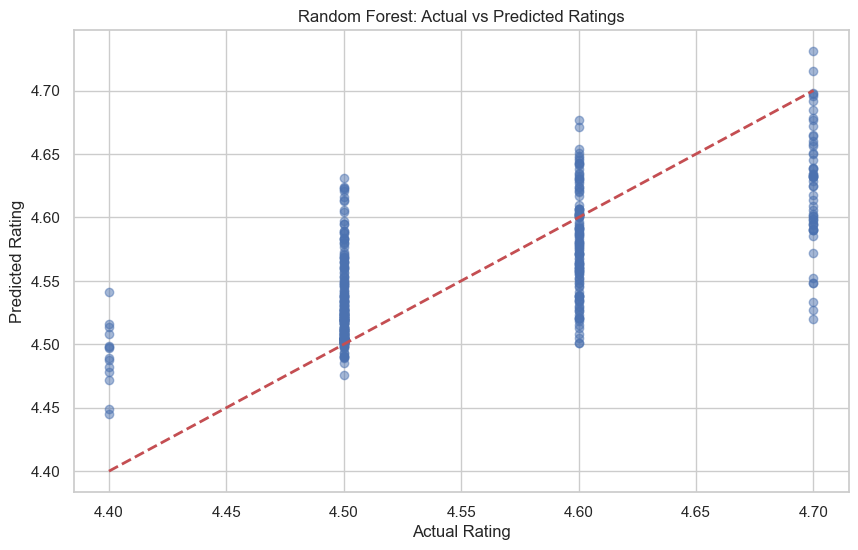

/var/folders/f2/mg40qcxd5ld3rvls_sfphpmc0000gn/T/ipykernel_12614/3155697545.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


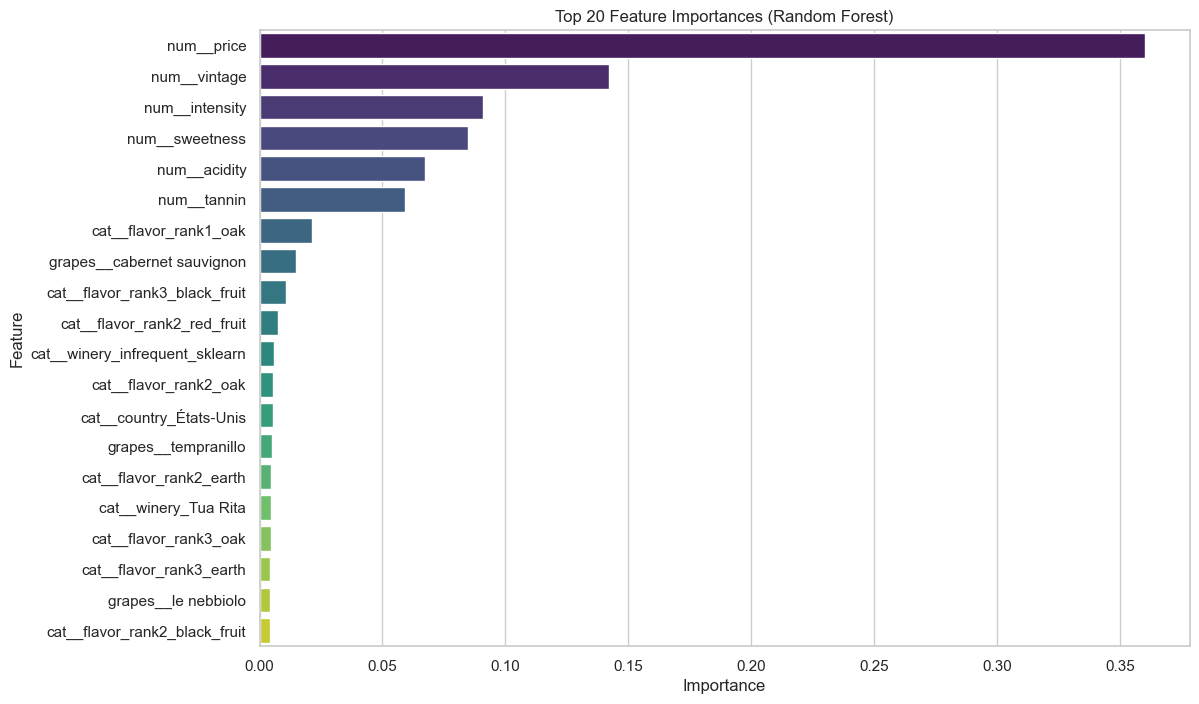

In [31]:
# Visualizing Model Performance

# 1. Actual vs Predicted (Random Forest)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Random Forest: Actual vs Predicted Ratings')
plt.show()

# 2. Feature Importance (Random Forest)
# Get feature names from the preprocessor
feature_names = []
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Fallback for older sklearn versions or if get_feature_names_out is not available
    # This is a simplified fallback and might not be perfect
    feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features))

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(20) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()